## 📦 [데이터셋] 전자상거래 배송 데이터 (Customer Analytics)

본 데이터셋은 국제 전자상거래 업체의 고객 데이터로, **제품 배송의 정시 도착 여부**를 분석하고 예측하기 위한 목적으로 구성되었습니다.

### 1. 타겟 변수 (Target Variable)
* **Reached.on.Time_Y.N**: 제품의 정시 도착 여부
    * **1**: 지연 도착 (Delayed)
    * **0**: 정시 도착 (On Time)

---

### 2. 데이터 컬럼 상세 설명 (Features)

| 컬럼명 | 설명 | 데이터 타입 | 비고 (Perspective) |
| :--- | :--- | :--- | :--- |
| **ID** | 고객 고유 식별 번호 | Integer | 예측 모델 구축 시 제거 대상 |
| **Warehouse_block** | 창고 구역 (A, B, C, D, E) | Object | 구역별 물류 부하 및 병목 현상 확인 |
| **Mode_of_Shipment** | 배송 수단 (Ship, Flight, Road) | Object | 수단별 지연율(지연 비중) 분석의 핵심 |
| **Customer_care_calls** | 고객 센터 문의 전화 횟수 | Integer | 배송 지연에 따른 고객 불만 척도 |
| **Customer_rating** | 고객 만족도 점수 (1~5) | Integer | 지연 여부와 만족도의 상관관계 분석 |
| **Cost_of_the_Product** | 제품 가격 (USD) | Integer | 고가 제품의 우선 배송 여부 확인 |
| **Prior_purchases** | 이전 구매 횟수 | Integer | 충성 고객 대상 배송 서비스 수준 확인 |
| **Product_importance** | 제품 중요도 (low, med, high) | Object | 중요도에 따른 배송 지연 차이 존재 여부 |
| **Gender** | 고객 성별 (F, M) | Object | 성별에 따른 구매 패턴 차이 확인 |
| **Discount_offered** | 할인 금액 | Integer | **핵심 가설:** 할인 폭이 크면 주문 폭주로 지연 가능성 높음 |
| **Weight_in_gms** | 제품 무게 (g) | Integer | 무게에 따른 배송 수단 제한 및 지연 영향 |

---

### 3. 분석 전략 (Initial Strategy)

1. **데이터 정제:** ID 컬럼 삭제 및 범주형 변수(Warehouse, Mode 등) 수치화.
2. **핵심 가설 검증:** - 할인(`Discount_offered`)과 배송 지연(`1`)의 상관관계 분석.
   - 제품 무게(`Weight_in_gms`)가 배송 수단별 지연에 미치는 영향 분석.
3. **성능 지표:** 모델의 예측 성능은 **ROC-AUC** 점수를 기준으로 평가함.

## 0. 데이터 불러오기, 기본 코드

In [1]:
#!/bin/bash
# !kaggle datasets download prachi13/customer-analytics

In [ ]:
#import zipfile
import os

HOME = os.getcwd()
HOME

# zip_file_path = 'customer-analytics.zip'

# extract_to_path = 'data'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

'c:\\Users\\min2m\\github\\project\\E-commerce\\KHM'

In [154]:
import platform
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분할 및 하이퍼파라미터 튜닝
from sklearn.model_selection import train_test_split, GridSearchCV

# 데이터 전처리 및 성능 평가 지표
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    classification_report
)

# 머신러닝 알고리즘 (부스팅, 앙상블 등)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# 1. 환경 설정 및 경고 무시
# ---------------------------------------------------------
warnings.filterwarnings('ignore') # 모든 FutureWarning 및 경고 무시

# 2. 한글 폰트 설정 (OS별 대응)
# ---------------------------------------------------------
if platform.system() == 'Darwin':     # 맥(macOS)
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

In [4]:
Train = pd.read_csv(os.path.join(HOME, 'data','Train.csv'))

In [5]:
Train.columns

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')

## 구하고자 하는 것



### 검증용 데이터 분리

In [ ]:
# 1. stratify 옵션을 써서 정답(Reached.on.Time_Y.N) 비율을 유지하며 8:2로 나눕니다.
# 이 함수는 내부적으로 데이터를 랜덤하게 섞어주기 때문에 sample을 따로 안 써도 됩니다.
part1, part2 = train_test_split(Train, 
                                test_size=0.2, 
                                random_state=42, 
                                stratify=Train['Reached.on.Time_Y.N'])

# 2. 각각 파일로 저장
part1.to_csv('data/train_df.csv', index=False)
part2.to_csv('data/test_df.csv', index=False)

print("데이터 분할 및 저장 완료!")
print(f"학습용: {part1.shape}, 테스트용: {part2.shape}")

데이터 분할 및 저장 완료!
학습용: (8799, 12), 테스트용: (2200, 12)


In [7]:
Train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/test_df.csv')

Train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,7921,D,Road,4,1,261,2,medium,F,9,4158,0
1,1530,F,Ship,3,3,162,2,low,F,26,1659,1
2,10522,B,Ship,3,2,221,2,medium,M,9,4466,0
3,9559,D,Ship,3,5,157,4,medium,F,2,4640,0
4,969,A,Flight,2,5,272,2,low,M,24,3638,1


In [8]:
print(Train.columns)

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')


## 컬럼별 데이터 확인 및 분석

### 1. ID --> drop

In [9]:
# id 중복 확인 -> 동일한 행 0
# 1. 전체 데이터프레임에서 완전히 똑같은 행이 있는지 확인
total_duplicates = Train.duplicated().sum()
print(f"완전히 동일한 행의 개수: {total_duplicates}")

# 2. 'ID' 컬럼만 기준으로 중복이 있는지 확인
id_duplicates = Train.duplicated(subset=['ID']).sum()
print(f"중복된 ID의 개수: {id_duplicates}")

# 3. 만약 중복이 있다면? (눈으로 직접 확인)
if id_duplicates > 0:
    print("--- 중복된 ID 데이터 샘플 ---")
    print(Train[Train.duplicated(subset=['ID'], keep=False)].sort_values('ID'))

완전히 동일한 행의 개수: 0
중복된 ID의 개수: 0


In [10]:
# ID drop
# [1] ID 컬럼 삭제 (inplace=True를 쓰면 원본이 바로 바뀝니다)
Train.drop(columns=['ID'], inplace=True)

# [2] 삭제 확인
print(f"현재 남은 컬럼: {Train.columns.tolist()}")

현재 남은 컬럼: ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']


### 2. Warehouse_block --> 약한 영향력의 변수 / 구역별 지연율 차이 2% 미만

--- 창고 구역별 물동량 현황 ---
Warehouse_block
F    2910
B    1487
D    1470
A    1468
C    1464
Name: count, dtype: int64


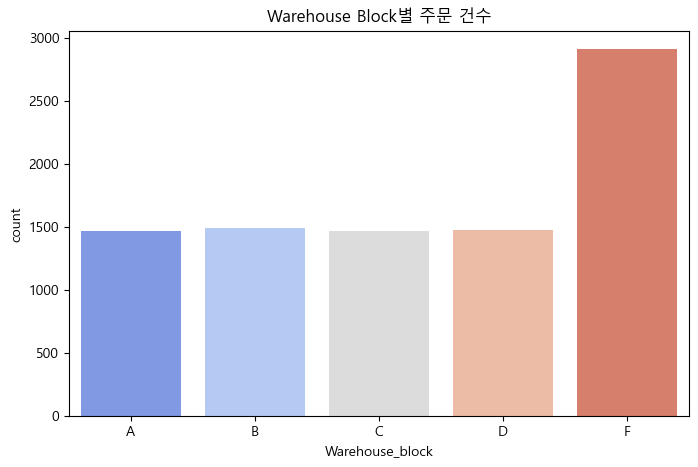

In [11]:
# 1. 구역별 주문 건수(물동량) 확인
warehouse_counts = Train['Warehouse_block'].value_counts()
print("--- 창고 구역별 물동량 현황 ---")
print(warehouse_counts)

# 2. 시각화 (막대 그래프)
plt.figure(figsize=(8, 5))
sns.countplot(data=Train, x='Warehouse_block', 
              order=['A', 'B', 'C', 'D', 'F'], # 알파벳 순서대로 정렬
              palette='coolwarm')
plt.title("Warehouse Block별 주문 건수")
plt.show()

> F 구역이 가장 큰 메인 허브거나 빈번하게 나가는 특정 품목 보관 장소일 확률

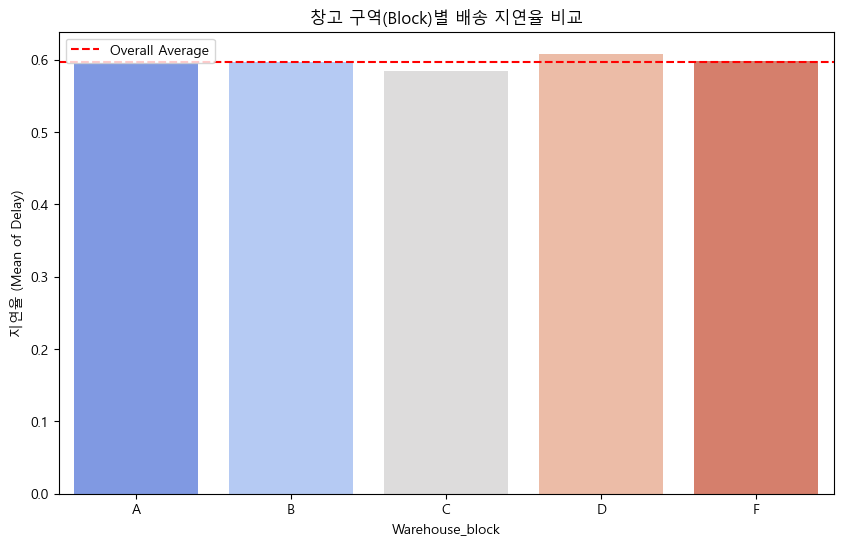

  Warehouse_block  Reached.on.Time_Y.N
3               D             0.608163
4               F             0.598282
1               B             0.596503
0               A             0.594687
2               C             0.584016


In [12]:
# [1] 창고 구역별 지연율(평균) 계산
warehouse_delay_rate = Train.groupby('Warehouse_block')['Reached.on.Time_Y.N'].mean().reset_index()

# [2] 시각화 (Barplot)
plt.figure(figsize=(10, 6))
sns.barplot(data=warehouse_delay_rate, x='Warehouse_block', y='Reached.on.Time_Y.N', palette='coolwarm')

# 전체 평균 지연율을 점선으로 표시 (기준선)
plt.axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Average')

plt.title('창고 구역(Block)별 배송 지연율 비교')
plt.ylabel('지연율 (Mean of Delay)')
plt.legend()
plt.show()

# [3] 수치로 정확히 확인
print(warehouse_delay_rate.sort_values(by='Reached.on.Time_Y.N', ascending=False))

> 결론: F 물류가 거의 2배 많은데 지연율이 비슷하다면 창고 구역 자체는 지연의 원인이 아니고, 창고 안에서의 이동보다 창고 밖에서의 배송 수단이나 물건 무게 등 다른 요소가 더 큰 문제일 확률이 높다

#### 2-2. 다른 요소도 확인

--- 창고 구역별 평균 제품 무게 ---
  Warehouse_block  Weight_in_gms
0               A    3578.709128
1               B    3649.040350
2               C    3647.191257
3               D    3645.260544
4               F    3633.500000


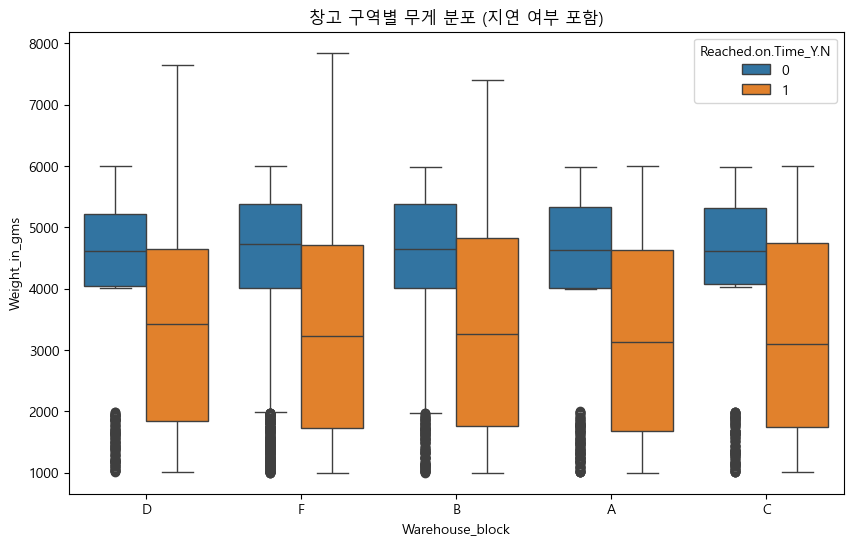

In [13]:
# 물건 무게가 유독 높은 곳이 있는가?

# [1] 창고 구역별 평균 무게 확인
warehouse_weight = Train.groupby('Warehouse_block')['Weight_in_gms'].mean().reset_index()
print("--- 창고 구역별 평균 제품 무게 ---")
print(warehouse_weight)

# [2] 시각화로 한눈에 비교 (Boxplot이 제맛!)
plt.figure(figsize=(10, 6))
sns.boxplot(data=Train, x='Warehouse_block', y='Weight_in_gms', hue='Reached.on.Time_Y.N')
plt.title('창고 구역별 무게 분포 (지연 여부 포함)')
plt.show()

--- 창고 구역별 제품 중요도 비중 (%) ---
Product_importance      high        low     medium
Warehouse_block                                   
A                   8.651226  50.000000  41.348774
B                   8.338937  45.998655  45.662408
C                   9.631148  47.472678  42.896175
D                   9.183673  47.823129  42.993197
F                   8.281787  48.041237  43.676976


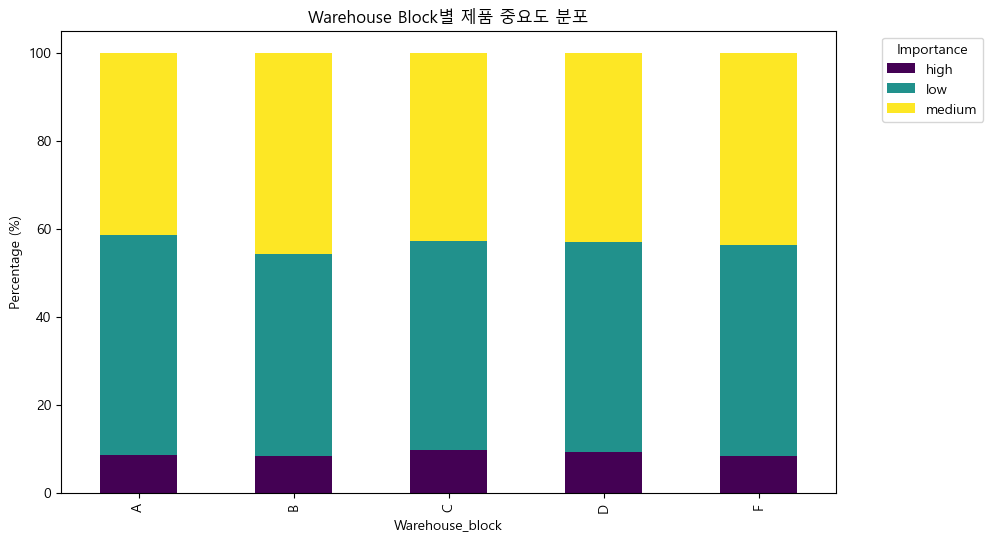

In [14]:
# 제품 중요도가 높은 게 많이 들어가는 창고?

# [2-1] 창고별 제품 중요도 비중 확인 (교차표)
importance_cross = pd.crosstab(Train['Warehouse_block'], Train['Product_importance'], normalize='index') * 100
print("--- 창고 구역별 제품 중요도 비중 (%) ---")
print(importance_cross)

# [2-2] 시각화 (누적 막대 그래프)
importance_cross.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Warehouse Block별 제품 중요도 분포')
plt.ylabel('Percentage (%)')
plt.legend(title='Importance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

--- 창고 구역별 배송 수단 비중 (%) ---
Mode_of_Shipment     Flight       Road       Ship
Warehouse_block                                  
A                 16.485014  16.280654  67.234332
B                 16.072629  16.139879  67.787492
C                 16.188525  16.120219  67.691257
D                 15.918367  16.122449  67.959184
F                 16.082474  15.326460  68.591065


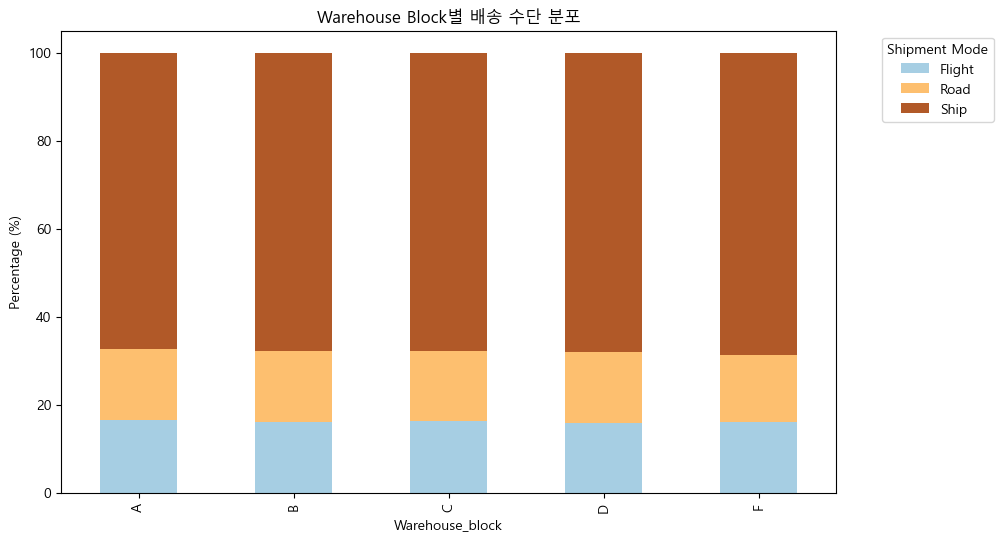

In [15]:
# 배송 수단별 비교

# [3-1] 창고별 배송 수단 비중 확인
shipment_cross = pd.crosstab(Train['Warehouse_block'], Train['Mode_of_Shipment'], normalize='index') * 100
print("--- 창고 구역별 배송 수단 비중 (%) ---")
print(shipment_cross)

# [3-2] 시각화 (누적 막대 그래프)
shipment_cross.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Paired')
plt.title('Warehouse Block별 배송 수단 분포')
plt.ylabel('Percentage (%)')
plt.legend(title='Shipment Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

> 다른 변수 추가해도 큰 영향력 없음

In [16]:
print(Train.columns)

Index(['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')


### 3. Mode_of_Shipment --> 약한 영향력의 변수
* 일반적 시각
* Ship (배): 가장 저렴하고 많이 실을 수 있지만, 기상 악화나 항만 적체에 매우 취약 (지연 가능성 높음)
* Flight (비행기): 가장 빠르지만 통관 절차가 복잡하고 비용이 비쌈 (속도는 빠르나 행정적 지연 가능성)
* Road (도로): 근거리 배송에 유리하지만 교통 체증이라는 변수

--- 배송 수단별 주문 건수 ---
Mode_of_Shipment
Ship      5981
Flight    1420
Road      1398
Name: count, dtype: int64

--- 배송 수단별 지연율 (평균) ---
Mode_of_Shipment
Flight    0.604225
Ship      0.597057
Road      0.587268
Name: Reached.on.Time_Y.N, dtype: float64


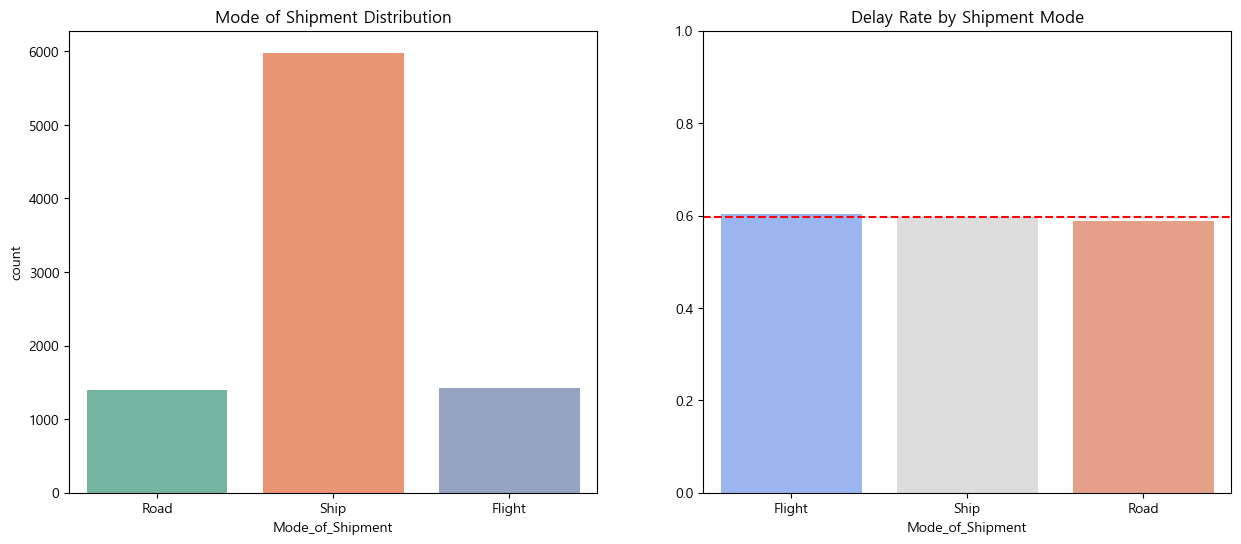

In [17]:
# [1] 낱개 분석: 회사는 주로 뭘 이용하나?
shipment_counts = Train['Mode_of_Shipment'].value_counts()
print("--- 배송 수단별 주문 건수 ---")
print(shipment_counts)

# [2] 지연율 분석: 누가 제일 느린가?
shipment_delay = Train.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean().sort_values(ascending=False)
print("\n--- 배송 수단별 지연율 (평균) ---")
print(shipment_delay)

# [3] 시각화 (한 번에 보기)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 왼쪽: 수단별 물량 분포
sns.countplot(data=Train, x='Mode_of_Shipment', ax=axes[0], palette='Set2')
axes[0].set_title('Mode of Shipment Distribution')

# 오른쪽: 수단별 지연율 (전체 평균선 포함)
sns.barplot(x=shipment_delay.index, y=shipment_delay.values, ax=axes[1], palette='coolwarm')
axes[1].axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
axes[1].set_title('Delay Rate by Shipment Mode')
axes[1].set_ylim(0, 1)

plt.show()

> 해상 운송 기반의 물류 회사. 수단별 차이 근소->물건자체의 속성이 중요한가?

#### 3-2. + 무게

--- 배송 수단 및 지연 여부별 평균 무게 ---
Reached.on.Time_Y.N            0            1
Mode_of_Shipment                             
Flight               4066.503559  3291.406760
Road                 4071.902946  3320.848965
Ship                 4189.323237  3267.879586


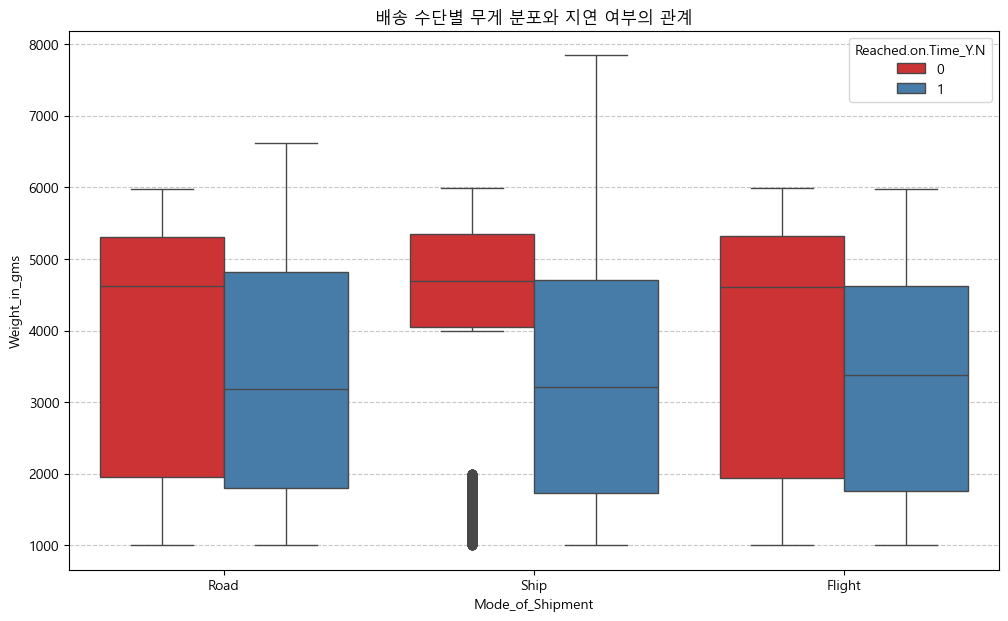

In [18]:
# 무게
# # [1] 수단별, 지연 여부별 '평균 무게' 확인
weight_stats = Train.groupby(['Mode_of_Shipment', 'Reached.on.Time_Y.N'])['Weight_in_gms'].mean().unstack()
print("--- 배송 수단 및 지연 여부별 평균 무게 ---")
print(weight_stats)

# [2] 시각화: 수단별 무게 분포와 지연의 상관관계
plt.figure(figsize=(12, 7))
sns.boxplot(data=Train, x='Mode_of_Shipment', y='Weight_in_gms', hue='Reached.on.Time_Y.N', palette='Set1')

plt.title('배송 수단별 무게 분포와 지연 여부의 관계')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

> 지연율: 비행기(60.4%), 배(59.7%), 자동차(58.7%) / 수단별로 차이 1%p 내외
>  + 무게가 더 큰 요소일 확률 높음 -> 무게 컬럼 분석 때 다시 확인

### 4~5. Customer_care_calls, Customer_rating --> drop이 유리

In [19]:
# 1. 배송 지연 여부에 따른 평점 차이
print(Train.groupby('Reached.on.Time_Y.N')['Customer_rating'].mean())

# 2. 고객 센터 전화 횟수와 평점의 관계 (불만이 점수로 이어지는지 확인)
# 전화를 많이 할수록 평점이 낮아진다면 '서비스 점수'일 확률
print(Train.groupby('Customer_care_calls')['Customer_rating'].mean())

Reached.on.Time_Y.N
0    2.971823
1    3.014667
Name: Customer_rating, dtype: float64
Customer_care_calls
2    3.043651
3    2.966487
4    2.985659
5    2.982590
6    3.126238
7    3.067010
Name: Customer_rating, dtype: float64


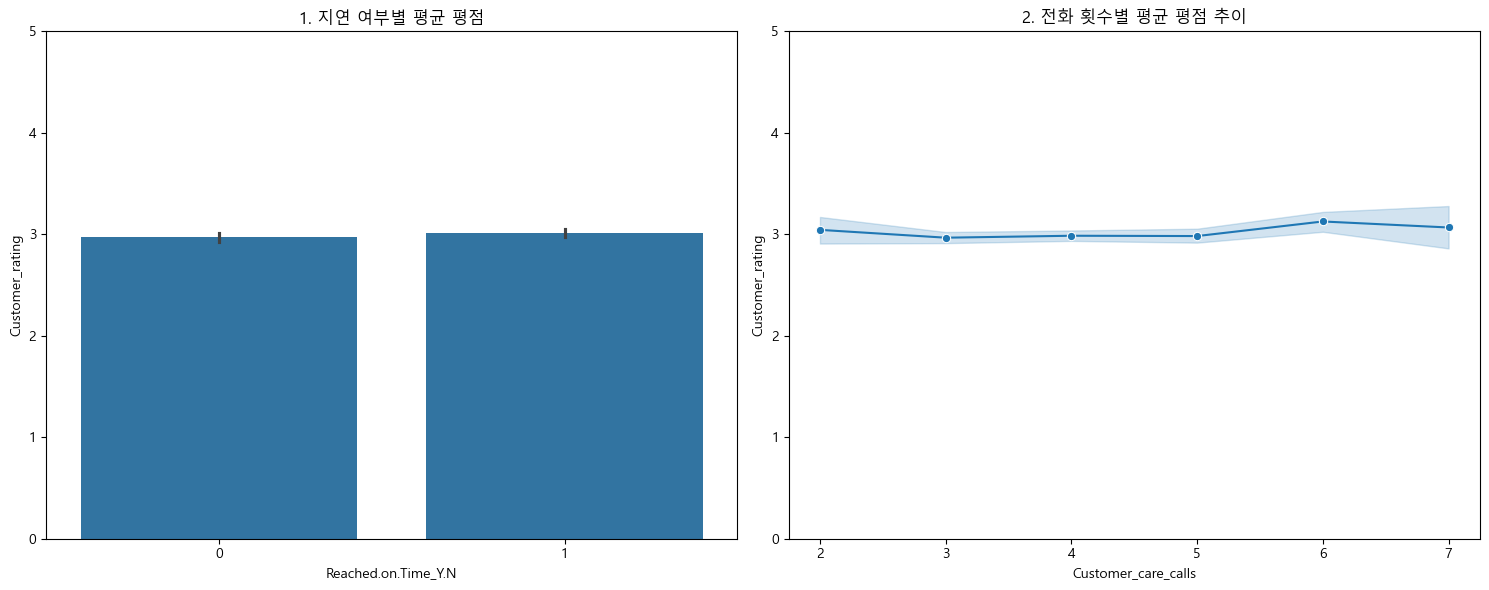

In [20]:
# 한 화면에 2개의 그래프
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# [1] 지연 여부에 따른 평점 평균 (Barplot)
sns.barplot(ax=axes[0], data=Train, x='Reached.on.Time_Y.N', y='Customer_rating')
axes[0].set_title('1. 지연 여부별 평균 평점')
axes[0].set_ylim(0, 5) # 평점은 1~5점 사이니까 범위를 고정!

# [2] 전화 횟수에 따른 평점 평균 (Lineplot)
# 변화의 흐름을 보기 위해 선 그래프를 씁니다.
sns.lineplot(ax=axes[1], data=Train, x='Customer_care_calls', y='Customer_rating', marker='o')
axes[1].set_title('2. 전화 횟수별 평균 평점 추이')
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.show()

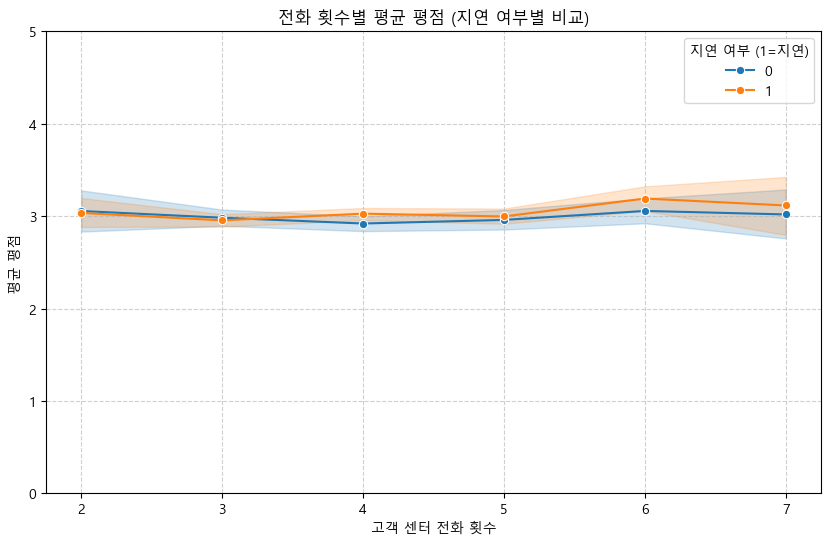

In [21]:
plt.figure(figsize=(10, 6))

# hue='Reached.on.Time_Y.N'을 추가해서 지연 여부별로 선을 나눕니다.
sns.lineplot(data=Train, x='Customer_care_calls', y='Customer_rating', 
             hue='Reached.on.Time_Y.N', marker='o')

plt.title('전화 횟수별 평균 평점 (지연 여부별 비교)')
plt.ylabel('평균 평점')
plt.xlabel('고객 센터 전화 횟수')
plt.ylim(0, 5)
plt.legend(title='지연 여부 (1=지연)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

가설1 : "배송이 늦더라도 **할인(Discount_offered)**이 높거나 제품이 마음에 들면 고객은 평점을 깎지 않는다. 즉, 고객은 속도보다 가격에 더 관대하다."

가설2 : "이 쇼핑몰 고객들은 평점을 줄 때 중간 점수(3점)를 주는 경향이 강하다." > 데이터로 확인할 수 없음

...????

> 가설 1 확인

Font 'rm' does not have a glyph for '\uc774' [U+c774], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\ud558' [U+d558], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\uc774' [U+c774], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\ud558' [U+d558], substituting with a dummy symbol.


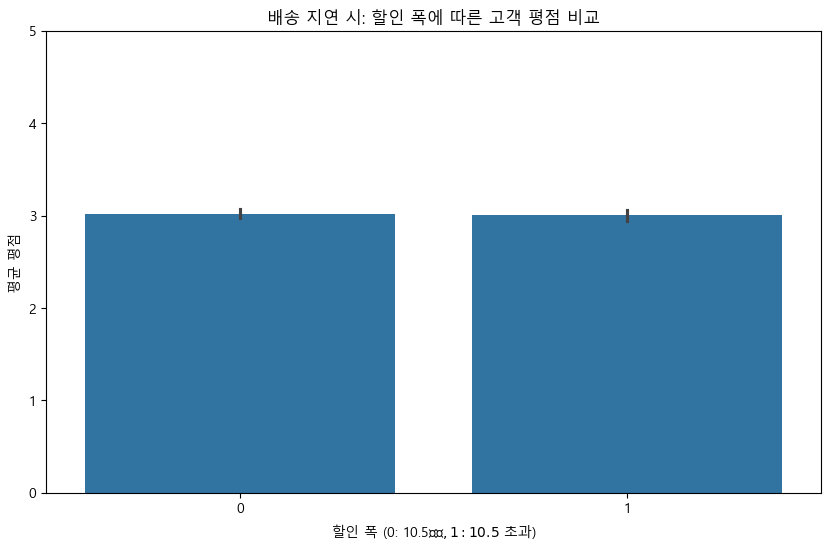

Is_High_Discount
0    3.020807
1    3.005644
Name: Customer_rating, dtype: float64


In [22]:
# [0-1] 먼저 Train 데이터에 Is_High_Discount 컬럼을 다시 만듭니다.
# 10.5달러 초과면 1, 아니면 0
Train['Is_High_Discount'] = (Train['Discount_offered'] > 10.5).astype(int)

# [0-2] 그 다음에 '지연된 데이터'만 따로 추출해야 Is_High_Discount가 포함됩니다.
delayed_shipments = Train[Train['Reached.on.Time_Y.N'] == 1].copy()

# 1. 지연된 데이터(Reached.on.Time_Y.N == 1)만 따로 추출
delayed_shipments = Train[Train['Reached.on.Time_Y.N'] == 1].copy()

# 2. 지연된 건들 중에서 '고할인' vs '저할인' 그룹의 평점 비교
plt.figure(figsize=(10, 6))
sns.barplot(data=delayed_shipments, x='Is_High_Discount', y='Customer_rating')

plt.title("배송 지연 시: 할인 폭에 따른 고객 평점 비교")
plt.xlabel("할인 폭 (0: 10.5$ 이하, 1: 10.5$ 초과)")
plt.ylabel("평균 평점")
plt.ylim(0, 5)
plt.show()

# 3. 수치로도 확인
print(delayed_shipments.groupby('Is_High_Discount')['Customer_rating'].mean())

> 큰 차이 X --> 통계적으로 변별력이 0에 수렴할 것으로 추정
* [Customer_rating], [Customer_care_calls] 컬럼은 drop 하는 것이 모델 학습에 유리함

### 6. Cost_of_the_Product --> 약한 영향력의 변수
* 가설: 비싼 물건은 빠르게 도착하지 않을까??

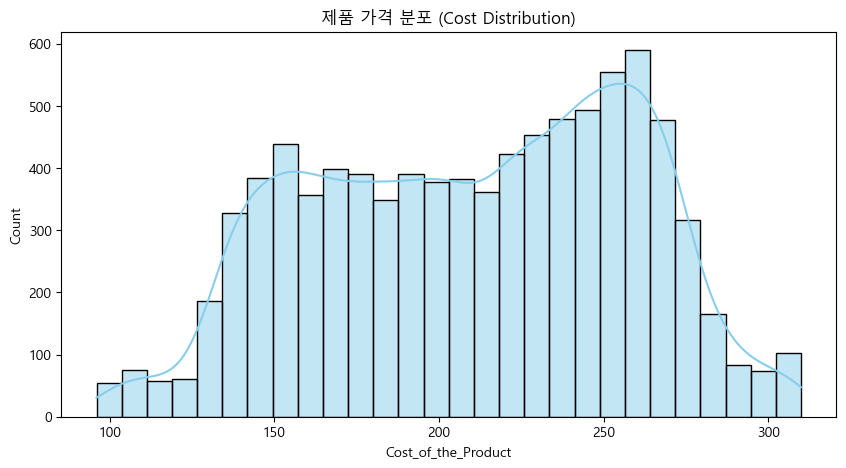

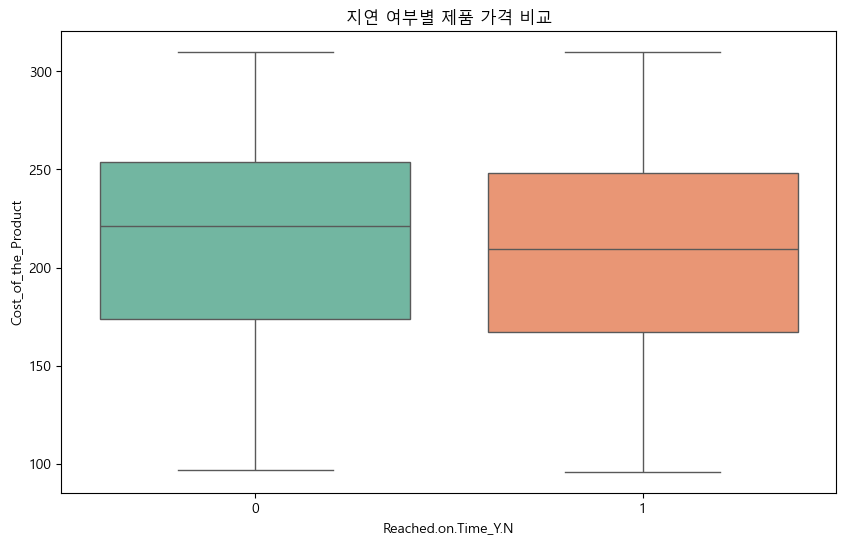

지연 여부별 평균 가격:
Reached.on.Time_Y.N
0    214.539870
1    207.317143
Name: Cost_of_the_Product, dtype: float64


In [23]:
# [1] 낱개 분석: 가격이 어떻게 분포되어 있나?
plt.figure(figsize=(10, 5))
sns.histplot(Train['Cost_of_the_Product'], kde=True, color='skyblue')
plt.title('제품 가격 분포 (Cost Distribution)')
plt.show()

# [2] 지연 여부에 따른 가격 차이 분석
plt.figure(figsize=(10, 6))
sns.boxplot(data=Train, x='Reached.on.Time_Y.N', y='Cost_of_the_Product', palette='Set2')
plt.title('지연 여부별 제품 가격 비교')
plt.show()

# [3] 수치로 확인
print("지연 여부별 평균 가격:")
print(Train.groupby('Reached.on.Time_Y.N')['Cost_of_the_Product'].mean())

> 가설 틀렸음 -> 비싸다고 제시간에 오지는 않음. (* 지연/정시 도착 가격이 비슷하게 형성되어 있음)

### 7. Prior_purchases --> ⭐ 유의미한 영향력의 변수
* 구매 횟수는 지연율을 최대 14%p(64%(3) -> 50%(5)) 변화 시킴

* 2~3회 (신규)	약 63~64%	지연율이 가장 높음 (관리 우선순위 낮음)
* 4회 (충성 진입)	약 53%	지연율이 급격히 감소 시작
* 5회 (Sweet Spot)	약 50%	이 데이터셋의 VIP 구간 (지연율 최저)
* 6회 이상 (단골)	약 57%	다시 소폭 상승하나 신규보다는 낮음

--- 과거 구매 횟수(Prior_purchases)별 지연율 ---
   Prior_purchases  Reached.on.Time_Y.N
0                2             0.626347
1                3             0.644563
2                4             0.538595
3                5             0.502434
4                6             0.543478
5                7             0.672566
6                8             0.666667
7               10             0.544218


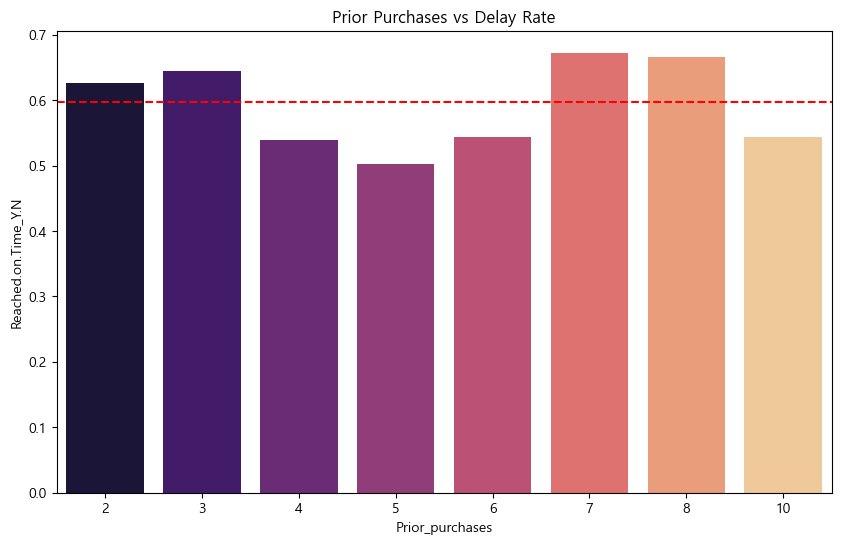

In [24]:
# [1] 과거 구매 횟수(Prior_purchases)별 지연율 계산
# mean()을 쓰는 이유는 1(지연)의 비중을 알기 위해서
prior_delay_rate = Train.groupby('Prior_purchases')['Reached.on.Time_Y.N'].mean().reset_index()

# [2] 결과 출력
print("--- 과거 구매 횟수(Prior_purchases)별 지연율 ---")
print(prior_delay_rate)

# [3] 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=prior_delay_rate, x='Prior_purchases', y='Reached.on.Time_Y.N', palette='magma')
plt.axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
plt.title('Prior Purchases vs Delay Rate')
plt.show()

* 2~3회 : 지연율이 62~64% (관심 밖?)
* 4~6회 : 지연율이 50~54% (가장 관리가 잘 됨!)
* 7회 이상 : 다시 지연율이 66~67% (왜?? 데이터 표본이 적은가?) >> 확인

In [25]:
# Prior_purchases별로 지연율(mean)과 데이터 개수(count)를 동시에 계산
prior_analysis = Train.groupby('Prior_purchases')['Reached.on.Time_Y.N'].agg(['mean', 'count']).reset_index()

# 컬럼 이름을 보기 좋게 바꿔줄게요
prior_analysis.columns = ['Prior_purchases', 'Delay_Rate', 'Sample_Size']

# 결과 확인
print("--- 과거 구매 횟수별 지연율 및 표본 크기 ---")
print(prior_analysis)

--- 과거 구매 횟수별 지연율 및 표본 크기 ---
   Prior_purchases  Delay_Rate  Sample_Size
0                2    0.626347         2042
1                3    0.644563         3182
2                4    0.538595         1723
3                5    0.502434         1027
4                6    0.543478          460
5                7    0.672566          113
6                8    0.666667          105
7               10    0.544218          147


* 2~5회는 샘플수가 1000~3000개 사이 6~10은 샘플수가 현저히 떨어짐
* 7회 이상의 지연율은 단골을 홀대하는게 아니라 표본이 적어서 생기는 문제일수도
* XGBoost 모델은 이를 과적합하여 판단할 수 있으므로 6~10회 체급을 비슷하게 묶어서 만들어줌

In [ ]:
# 'Prior_purchases'가 6 이상인 것들은 모두 6으로 통일 (별도 그룹화)
# 6, 7, 8, 10을 모두 '6'이라는 대표값으로 뭉치기
Train['Prior_purchases_cleaned'] = Train['Prior_purchases'].apply(lambda x: x if x < 6 else 6)

# 다시 한번 지연율과 개수를 확인
cleaned_analysis = Train.groupby('Prior_purchases_cleaned')['Reached.on.Time_Y.N'].agg(['mean', 'count'])
print(cleaned_analysis)

                             mean  count
Prior_purchases_cleaned                 
2                        0.626347   2042
3                        0.644563   3182
4                        0.538595   1723
5                        0.502434   1027
6                        0.576970    825


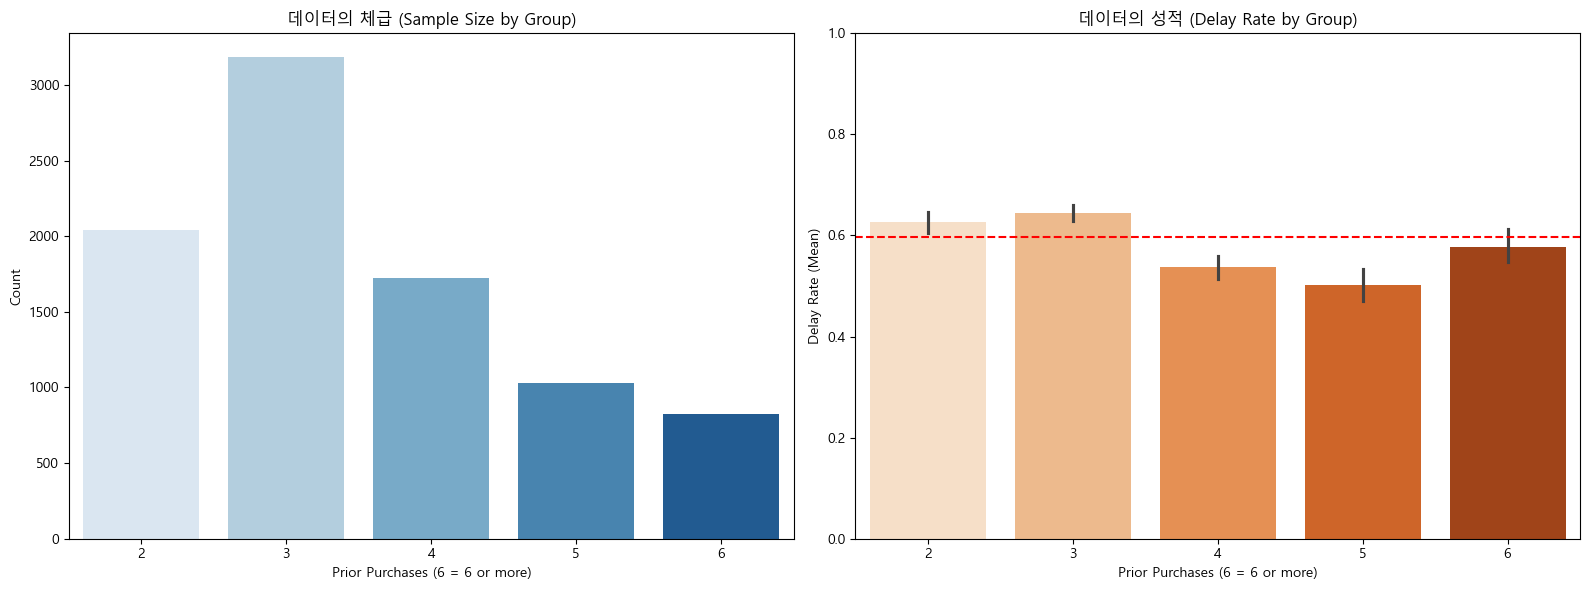

In [60]:
# [1] 시각화 준비
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# [2] 왼쪽: 데이터의 체급 (Sample Size)
# 뭉쳐진 데이터(6회 이상) 확인
sns.countplot(data=Train, x='Prior_purchases_cleaned', ax=axes[0], palette='Blues')
axes[0].set_title('데이터의 체급 (Sample Size by Group)')
axes[0].set_xlabel('Prior Purchases (6 = 6 or more)')
axes[0].set_ylabel('Count')

# [3] 오른쪽: 데이터의 성적 (Delay Rate)
# 5회 구간에서 지연율 떨어지는 구간 찾기
sns.barplot(data=Train, x='Prior_purchases_cleaned', y='Reached.on.Time_Y.N', ax=axes[1], palette='Oranges')
axes[1].axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
axes[1].set_title('데이터의 성적 (Delay Rate by Group)')
axes[1].set_xlabel('Prior Purchases (6 = 6 or more)')
axes[1].set_ylabel('Delay Rate (Mean)')
axes[1].set_ylim(0, 1) # 지연율 0~1 사이

plt.tight_layout()
plt.show()

* 2~3회 (신규)	약 63~64%	지연율이 가장 높음 (관리 우선순위 낮음) : * 추측: 할인을 많이해서 신규로 진입한 고객일수도?
* 4회 (충성 진입)	약 53%	지연율이 급격히 감소 시작
* 5회 (Sweet Spot)	약 50%	이 데이터셋의 VIP 구간 (지연율 최저)
* 6회 이상 (단골)	약 57%	다시 소폭 상승하나 신규보다는 낮음

> 가설검증 단계

In [61]:
# 구매 횟수(Prior_purchases)별 평균 할인액(Discount_offered) 계산
analysis = Train_ready.groupby('Prior_purchases')['Discount_offered'].mean()
print("--- 구매 횟수별 평균 할인액 ---")
print(analysis)

--- 구매 횟수별 평균 할인액 ---
Prior_purchases
2     15.292360
3     15.174104
4     10.647127
5      9.397274
6     10.930435
7     15.920354
8     12.838095
10    13.156463
Name: Discount_offered, dtype: float64


--- [결과] 구매 횟수별 가격/무게 통계 ---
   Prior_purchases  Cost_of_the_Product  Weight_in_gms  Discount_offered  \
0                2           201.906954    4011.672870         15.292360   
1                3           200.152734    4035.417976         15.174104   
2                4           228.233894    3122.888566         10.647127   
3                5           227.064265    2462.910419          9.397274   
4                6           217.554348    3218.371739         10.930435   
5                7           206.362832    4149.530973         15.920354   
6                8           199.904762    4189.028571         12.838095   
7               10           202.795918    4212.897959         13.156463   

   Reached.on.Time_Y.N  
0             0.626347  
1             0.644563  
2             0.538595  
3             0.502434  
4             0.543478  
5             0.672566  
6             0.666667  
7             0.544218  


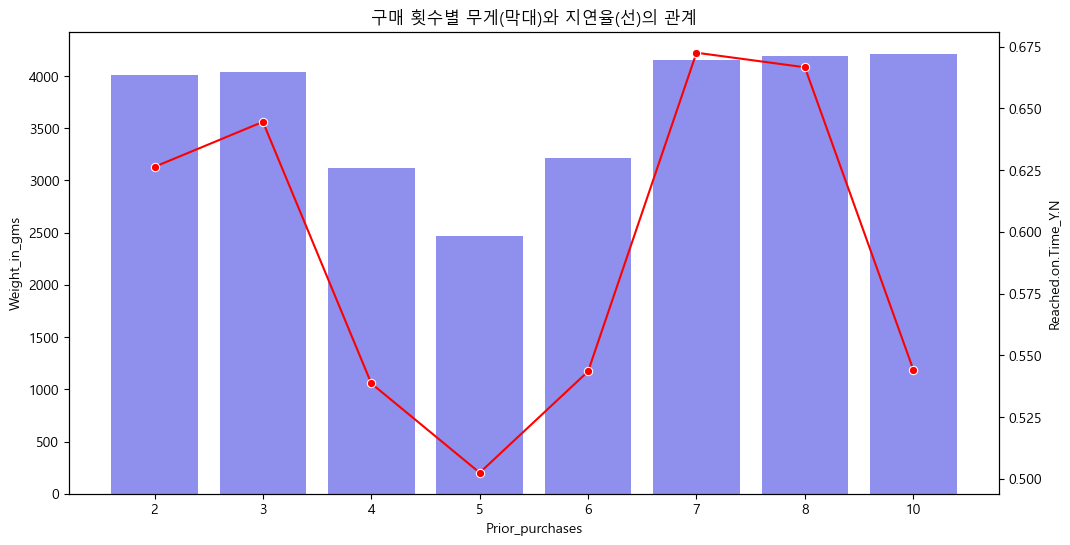

In [63]:
# [1 & 2] 구매 횟수별 평균 가격과 무게 확인
# 이 코드를 돌리면 우리 단골 고객들이 어떤 특징을 가졌는지 바로 보입니다.

loyalist_analysis = Train_ready.groupby('Prior_purchases').agg({
    'Cost_of_the_Product': 'mean',  # 1. 평균 가격
    'Weight_in_gms': 'mean',        # 2. 평균 무게
    'Discount_offered': 'mean',     # (참고용) 평균 할인액
    'Reached.on.Time_Y.N': 'mean'   # (참고용) 실제 지연율
}).reset_index()

print("--- [결과] 구매 횟수별 가격/무게 통계 ---")
print(loyalist_analysis)

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 무게와 지연율의 관계 시각화
sns.barplot(data=loyalist_analysis, x='Prior_purchases', y='Weight_in_gms', alpha=0.5, ax=ax1, color='blue')
ax2 = ax1.twinx()
sns.lineplot(data=loyalist_analysis, x=range(len(loyalist_analysis)), y='Reached.on.Time_Y.N', marker='o', color='red', ax=ax2)

plt.title("구매 횟수별 무게(막대)와 지연율(선)의 관계")
plt.show()

> 원인 추정: 단골 고객 유지를 위해 고액할인(평균13~16)을 제공함.

* "10달러 초과 할인시 지연" 로직이 단골 고객에게도 똑같이 적용됨 (할인이 많응면 주문이 몰리거나 저가 배송 수단을 선택할 가능성)

> 해결 전략
* 단골 고객은 별도의 단골 전용라인 택배로 지연율 강제 관리
* 단순 가격 할인보다 무료 특급 택배 서비스 제공 ? >> 근데 이건 배달 빨리 받았다고 만족률이 높다면 좋은 정책이지만 만족도 높지 않음.

> 추가 가설 (6번 이상 구매한 사람들 만족도 다를까?) >> 차이 없음

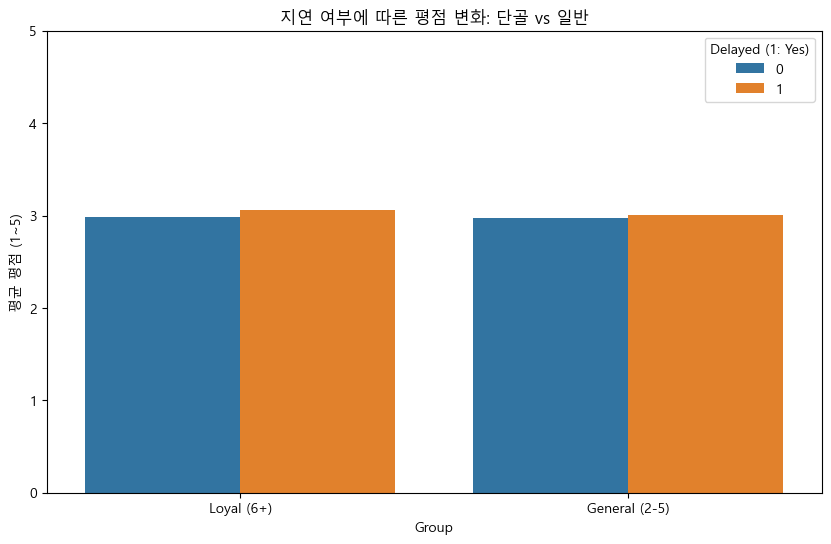

--- [수사 결과] 그룹별 지연 시 평점 하락폭 ---
   Reached.on.Time_Y.N  Customer_rating          Group
0                    0         2.988539     Loyal (6+)
1                    1         3.060924     Loyal (6+)
0                    0         2.970000  General (2-5)
1                    1         3.010054  General (2-5)


In [ ]:
# [1] 데이터 분리: 6회 이상(Loyal) vs 5회 이하(General)
loyal_df = Train_ready[Train_ready['Prior_purchases'] >= 6].copy()
general_df = Train_ready[Train_ready['Prior_purchases'] < 6].copy()

# [2] 지연 여부별 평균 평점 비교 데이터 생성
def get_rating_analysis(df, label):
    res = df.groupby('Reached.on.Time_Y.N')['Customer_rating'].mean().reset_index()
    res['Group'] = label
    return res

loyal_res = get_rating_analysis(loyal_df, 'Loyal (6+)')
general_res = get_rating_analysis(general_df, 'General (2-5)')

combined_res = pd.concat([loyal_res, general_res])

# [3] 시각화: 지연 여부에 따른 평점 변화 (단골 vs 일반)
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_res, x='Group', y='Customer_rating', hue='Reached.on.Time_Y.N')
plt.title("지연 여부에 따른 평점 변화: 단골 vs 일반")
plt.ylabel("평균 평점 (1~5)")
plt.ylim(0, 5)
plt.legend(title='Delayed (1: Yes)')
plt.show()

print("--- [결과] 그룹별 지연 시 평점 하락폭 ---")
print(combined_res)

⭐ 과적합(Overfitting) 방지 : 기존 Prior_purchases 대신, **Prior_purchases_cleaned**를 메인 변수로 사용

In [28]:
Train['Prior_purchases_cleaned'].unique()

array([2, 4, 3, 5, 6])

In [ ]:
# [1] 여기서 df는 가짜 이름
def get_cleaned_data(df):
    temp_df = df.copy() # 원본 보호를 위해 복사본 생성
    temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    temp_df = temp_df.drop('Prior_purchases', axis=1)
    return temp_df

# [2] 현실 (Train이 진짜)
# 원본 Train은 그대로 두고, 결과물만 Train_ready에 담기
Train_ready = get_cleaned_data(Train)

# [3] 구분 확인
print(f"원본 컬럼 개수: {len(Train.columns)}")       # Prior_purchases가 살아있음
print(f"전처리 컬럼 개수: {len(Train_ready.columns)}") # 새 변수만 있고 원본은 삭제됨

원본 컬럼 개수: 13
전처리 컬럼 개수: 12


In [30]:
print("--- 원본(Train) 컬럼 목록 ---")
print(Train.columns.tolist())

print("\n--- 전처리(Train_ready) 컬럼 목록 ---")
print(Train_ready.columns.tolist())

--- 원본(Train) 컬럼 목록 ---
['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N', 'Is_High_Discount', 'Prior_purchases_cleaned']

--- 전처리(Train_ready) 컬럼 목록 ---
['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N', 'Is_High_Discount', 'Prior_purchases_cleaned']


* Train : 원본
* Train_ready : 컬럼 바꾼 것

### 8. Product_importance  --> 유의미한 영향력의 변수 (조건부)
> 최악의 조합: High + Ship (0.66), High + Road(0.65)

> 의외로 괜찮음 : Medium + Road(0.56)
* 조건부 로직으로 확률을 높여볼까? (importance == high + mode == Ship인 데이터는 지연확률높음)

--- 제품 중요도별 지연율 성적표 ---
  Product_importance      mean  count
1                low  0.597532   4214
2             medium  0.585276   3817
0               high  0.648438    768


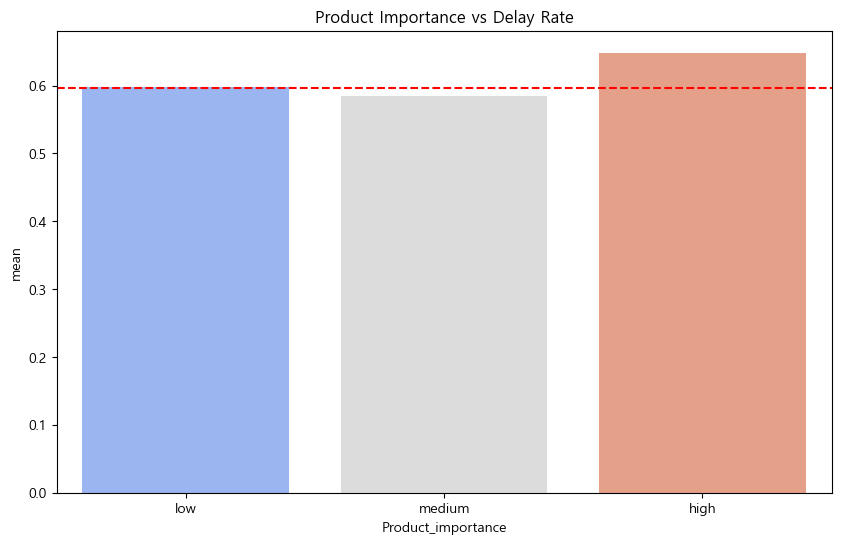

In [31]:
# [1] 제품 중요도별 지연율과 샘플 수 확인
importance_report = Train.groupby('Product_importance')['Reached.on.Time_Y.N'].agg(['mean', 'count']).reset_index()

# [2] 보기 좋게 정렬 (low -> medium -> high 순서로)
importance_report['Product_importance'] = pd.Categorical(importance_report['Product_importance'], categories=['low', 'medium', 'high'], ordered=True)
importance_report = importance_report.sort_values('Product_importance')

print("--- 제품 중요도별 지연율 성적표 ---")
print(importance_report)

# [3] 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_report, x='Product_importance', y='mean', palette='coolwarm')
plt.axhline(Train['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
plt.title('Product Importance vs Delay Rate')
plt.show()

> Low: 지연율 59.7% / Medium: 지연율 58.5% / High: 지연율 64.8%
* 샘플 수(count): high (768개), low(4,214개), medium(3,817개) / 노이즈가 섞여있을 확률 큼

* 추측의 영역 : 배송난이도? 중요도가 high인 제품들은 아마 비싸거나, 깨지기 쉽거나, 크기가 큰 제품일 가능성. 검수 과정이 더 까다롭거나 배송 기사님이 더 조심조심 다루다 보니 오히려 시간이 더 걸리지 않을까?

> 결론: 중요도가 높다고 빨리가지는 않음. 

In [32]:
# 라벨 인코딩 Label Encoding
def get_cleaned_data(df):
    temp_df = df.copy()
    
    # [1] 이전 구매 횟수 처리 (이미 처리함)
    temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    temp_df = temp_df.drop('Prior_purchases', axis=1)
    
    # [2] 제품 중요도 처리 (새로 추가!)
    # 글자를 숫자로 매핑
    mapping = {'low': 1, 'medium': 2, 'high': 3}
    temp_df['Product_importance'] = temp_df['Product_importance'].map(mapping)
    
    return temp_df

Train_ready = get_cleaned_data(Train)

In [33]:
# [체크 1] 인코딩 후 결측치 확인
print("인코딩 후 결측치 개수:", Train_ready['Product_importance'].isnull().sum())

# [체크 2] 상관계수 확인
correlation = Train_ready[['Product_importance', 'Reached.on.Time_Y.N']].corr()
print("--- 중요도와 지연율의 상관계수 ---")
print(correlation)

# [체크 3] 개수 비중 확인
print(Train_ready['Product_importance'].value_counts())

인코딩 후 결측치 개수: 0
--- 중요도와 지연율의 상관계수 ---
                     Product_importance  Reached.on.Time_Y.N
Product_importance             1.000000             0.013011
Reached.on.Time_Y.N            0.013011             1.000000
Product_importance
1    4214
2    3817
3     768
Name: count, dtype: int64


In [34]:
Train_ready.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Is_High_Discount,Prior_purchases_cleaned
0,D,Road,4,1,261,2,F,9,4158,0,0,2
1,F,Ship,3,3,162,1,F,26,1659,1,1,2
2,B,Ship,3,2,221,2,M,9,4466,0,0,2
3,D,Ship,3,5,157,2,F,2,4640,0,0,4
4,A,Flight,2,5,272,1,M,24,3638,1,1,2


#### 8-2. +다른변수 교차분석

--- 중요도와 운송수단별 지연율 ---
Mode_of_Shipment      Flight      Road      Ship
Product_importance                              
high                0.595420  0.651163  0.661417
low                 0.601199  0.594955  0.597285
medium              0.609325  0.564706  0.584231


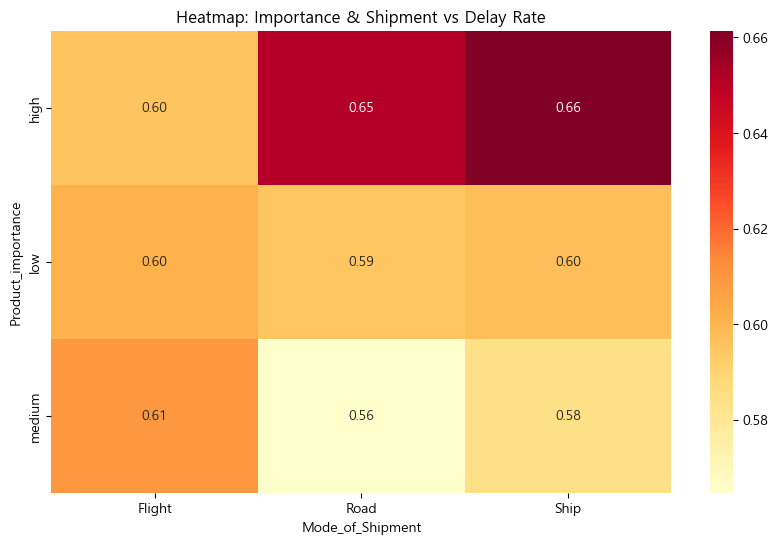

In [35]:
# [1] 중요도(Product_importance) x 운송수단(Mode_of_Shipment) 교차 분석
importance_ship_analysis = Train.groupby(['Product_importance', 'Mode_of_Shipment'])['Reached.on.Time_Y.N'].mean().unstack()

print("--- 중요도와 운송수단별 지연율 ---")
print(importance_ship_analysis)

# [2] 시각화: 히트맵으로 어디가 '지연'이 많이 되는지 확인
plt.figure(figsize=(10, 6))
sns.heatmap(importance_ship_analysis, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Heatmap: Importance & Shipment vs Delay Rate')
plt.show()

> 최악의 조합: High + Ship (0.66), High + Road(0.65)
> 의외로 괜찮음 : Medium + Road(0.56)

* 조건부 로직 importance == high 이면서 mode == Ship인 데이터는 일단 지연될 확률이 높아질듯

### 9. Gender --> drop

### 10. Discount_offer --> ⭐⭐⭐ 가장 높은 상관관계
>현상: 할인이 높으면 주문량이 폭주 / 10달러 초과한 할인은 100% 지연(1) 
>> 100% 지연구간을 이진수(0,1)로 표현하여 새로 컬럼 만듦 > 학습속도와 정확도를 올려줌 (모델이 10 이상인지 아닌지 확인하는 것보다 1,0으로 확인하는 게 더 빠름. 1이면 무조건 지연으로 처리할 수 있음)

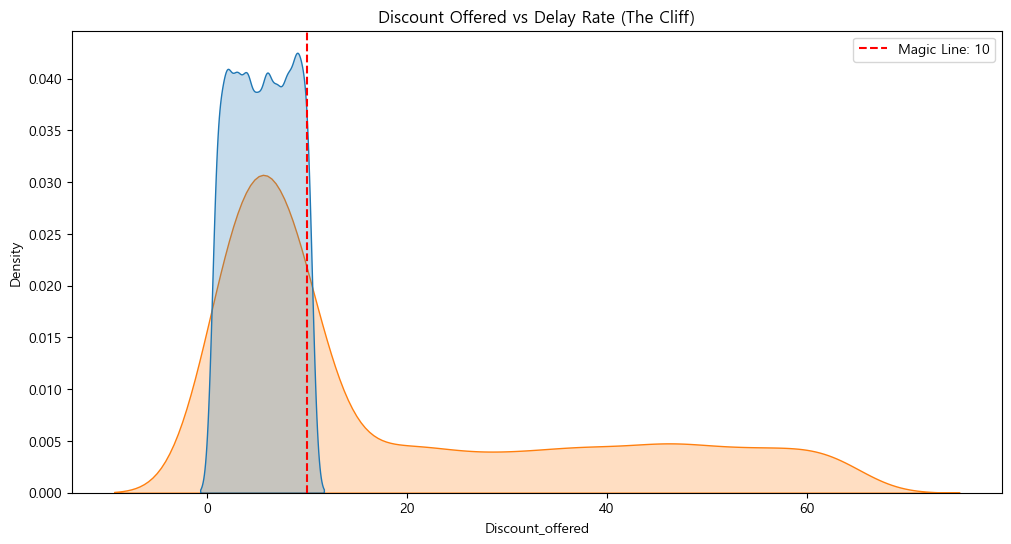

--- 10달러 할인 기준 지연율 비교 ---
over_10
False    0.468155
True     1.000000
Name: Reached.on.Time_Y.N, dtype: float64


In [36]:
# 전체적인 분포 확인

# [1] 할인 폭에 따른 지연(1)과 정시(0)의 분포 시각화
plt.figure(figsize=(12, 6))
sns.kdeplot(data=Train, x='Discount_offered', hue='Reached.on.Time_Y.N', fill=True)
plt.title('Discount Offered vs Delay Rate (The Cliff)')
plt.axvline(x=10, color='red', linestyle='--', label='Magic Line: 10')
plt.legend()
plt.show()

# [2] 숫자로 증명하기 (10달러 이하 vs 초과)
Train['over_10'] = Train['Discount_offered'] > 10
print("--- 10달러 할인 기준 지연율 비교 ---")
print(Train.groupby('over_10')['Reached.on.Time_Y.N'].mean())

* 할인 폭 1~10달러: 지연/정시 데이터가 섞여 있음 (운에 맡겨야 함)
* 할인 폭 10달러 초과: 정시(0)의 그래프가 0이 되는 지점이 보임
* 결론: 할인이 11달러 이상 -> 배송 무조건 지연 (100%)

배송 지연 여부별 평균 할인:
Reached.on.Time_Y.N
0     5.542688
1    18.656190
Name: Discount_offered, dtype: float64


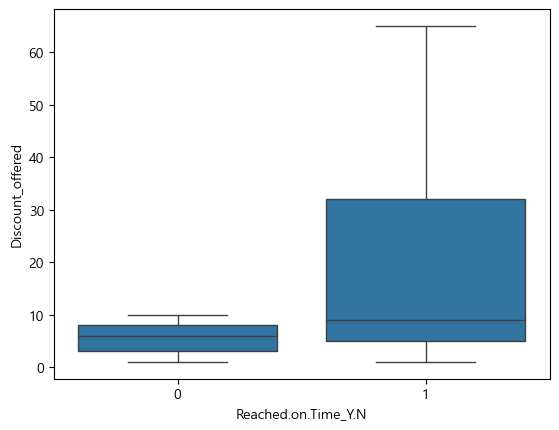

In [37]:
# 지연된 데이터만 모아보기
# 배송 지연 여부에 따른 할인 차이 확인

print("배송 지연 여부별 평균 할인:")
print(Train.groupby('Reached.on.Time_Y.N')['Discount_offered'].mean())

# 시각화
sns.boxplot(x='Reached.on.Time_Y.N', y='Discount_offered', data=Train)
plt.show()

>현상: 할인이 높으면 주문량 폭주

In [38]:
# 할인 10$를 기준으로 지연율 차이 계산
over_10 = Train[Train['Discount_offered'] > 10]['Reached.on.Time_Y.N'].mean()
under_10 = Train[Train['Discount_offered'] <= 10]['Reached.on.Time_Y.N'].mean()

print(f"할인 10$ 초과 시 지연율: {over_10:.2%}")
print(f"할인 10$ 이하 시 지연율: {under_10:.2%}")

할인 10$ 초과 시 지연율: 100.00%
할인 10$ 이하 시 지연율: 46.82%


In [39]:
def get_cleaned_data(df):
    temp_df = df.copy() # [A] 원본 보호:
    
    # 1. 이전 구매 횟수 처리
    # [B] 6 이상 뭉치기: 데이터의 희소성(Sparsity) 문제를 로직으로 해결함.
    # temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    # temp_df = temp_df.drop('Prior_purchases', axis=1) # 원본 삭제
    
    # # 2. 제품 중요도 라벨 인코딩
    # # [C] Ordinal Encoding: low < medium < high의 '급'을 모델에게 숫자로 주입
    # mapping = {'low': 1, 'medium': 2, 'high': 3}
    # temp_df['Product_importance'] = temp_df['Product_importance'].map(mapping)
    
    # 3. 할인 폭 처리
    # [D] Is_Danger_Discount
    # 100% 지연구간을 이진수(0,1)로 표현
    temp_df['Is_Danger_Discount'] = (temp_df['Discount_offered'] > 10).astype(int)
    
    return temp_df

Train_ready = get_cleaned_data(Train)
Train_ready

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Is_High_Discount,Prior_purchases_cleaned,over_10,Is_Danger_Discount
0,D,Road,4,1,261,2,medium,F,9,4158,0,0,2,False,0
1,F,Ship,3,3,162,2,low,F,26,1659,1,1,2,True,1
2,B,Ship,3,2,221,2,medium,M,9,4466,0,0,2,False,0
3,D,Ship,3,5,157,4,medium,F,2,4640,0,0,4,False,0
4,A,Flight,2,5,272,2,low,M,24,3638,1,1,2,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8794,B,Road,4,4,204,3,low,F,9,4757,0,0,3,False,0
8795,C,Ship,4,2,237,3,low,F,7,4785,0,0,3,False,0
8796,D,Flight,4,1,140,4,low,M,6,5067,0,0,4,False,0
8797,B,Ship,4,4,251,2,medium,F,6,4376,0,0,2,False,0


### 11. Weight_in_gms --> ⭐⭐ 높은 상관관계

* 정시 구역 (Safe Zone): 아주 가볍거나(1000~2000g), 아주 무거운(4000~6000g) 물건들은 지연율이 상대적으로 낮음
* 지연 구역 (Danger Zone): 2000g에서 4000g 사이 물건들은 지연율이 **90~100%**
> 2~4kg 물건이 늦게 오는 이유는 그 무게의 할인이 높기 때문인 경우가 많았음. 무게보다는 할인이 더 큰 영향력
* ! 2~4kg는 샘플수가 충분하지만 6kg 이상 데이터는 count가 1개씩 데이터가 부족 

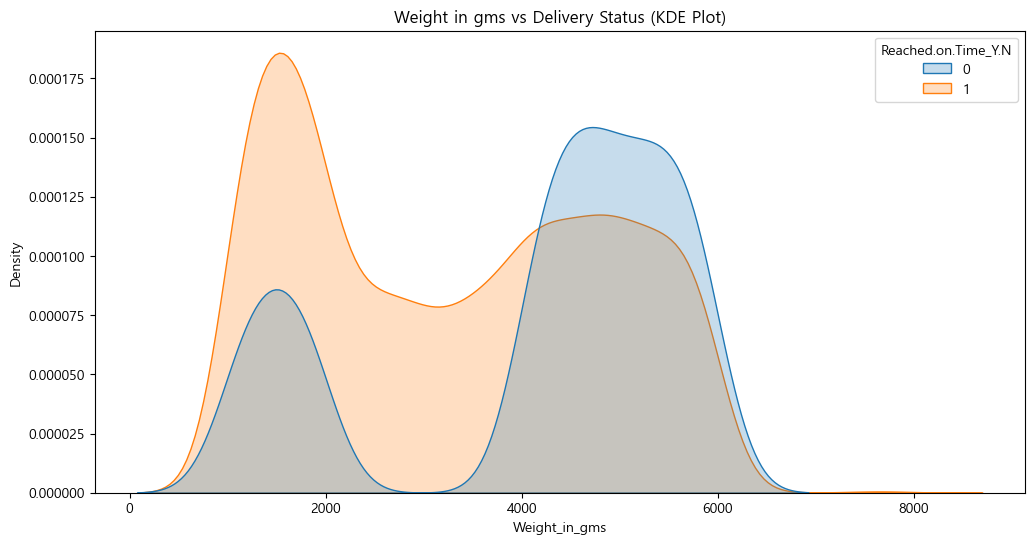

--- 무게 구간별 지연율 성적표 ---
Weight_Bin
(1000, 1500]    0.674080
(1500, 2000]    0.668478
(2000, 2500]    1.000000
(2500, 3000]    1.000000
(3000, 3500]    1.000000
(3500, 4000]    0.997361
(4000, 4500]    0.448191
(4500, 5000]    0.422240
(5000, 5500]    0.434245
(5500, 6000]    0.425000
(6000, 6500]    1.000000
(6500, 7000]    1.000000
(7000, 7500]    1.000000
Name: Reached.on.Time_Y.N, dtype: float64


In [40]:
# 무게 분포 확인
# [1] 무게에 따른 지연(1)과 정시(0)의 분포 확인 (KDE Plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=Train, x='Weight_in_gms', hue='Reached.on.Time_Y.N', fill=True)
plt.title('Weight in gms vs Delivery Status (KDE Plot)')
plt.show()

# [2] 숫자로 더 자세히 보기 위해 무게를 500g 단위로 쪼개서 확인
Train['Weight_Bin'] = pd.cut(Train['Weight_in_gms'], bins=range(1000, 8000, 500))
weight_analysis = Train.groupby('Weight_Bin')['Reached.on.Time_Y.N'].mean()

print("--- 무게 구간별 지연율 성적표 ---")
print(weight_analysis)

* 정시 구역 (Safe Zone): 아주 가볍거나(1000~2000g), 아주 무거운(4000~6000g) 물건들은 지연율이 상대적으로 낮음
* 지연 구역 (Danger Zone): 2000g에서 4000g 사이 물건들은 지연율이 **90~100%**

가벼운 물건: 퀵서비스나 소형 전용 라인으로 빠르게 처리될 수 있음

무거운 물건: 대형 화물 전용 차량으로 계획적으로 배송

애매한 무게 (2~4kg): 소형으로 분류하기엔 무겁고, 대형으로 분류하기엔 작아서 물류 센터 한구석에 쌓여 있다가 처리가 밀릴 가능성이 크다. 
혹은 특정 프로모션(할인 많이 해주는 제품군)이 이 무게에 집중되어 있을 수도 있음 >> 이건 확인 가능할 듯?

--- 무게 구간별 할인폭 실태조사 ---
                   mean  max  count
Weight_Bin                         
(1000, 1500]  16.725460   65   1304
(1500, 2000]  16.746118   65   1288
(2000, 2500]  33.060109   65    366
(2500, 3000]  32.010695   65    374
(3000, 3500]  34.195783   65    332
(3500, 4000]  32.641161   65    379
(4000, 4500]   5.481086   10   1216
(4500, 5000]   5.545528   10   1241
(5000, 5500]   5.563989   10   1133
(5500, 6000]   5.524138   10   1160
(6000, 6500]   5.000000    5      1
(6500, 7000]  22.000000   22      1
(7000, 7500]  31.000000   31      1


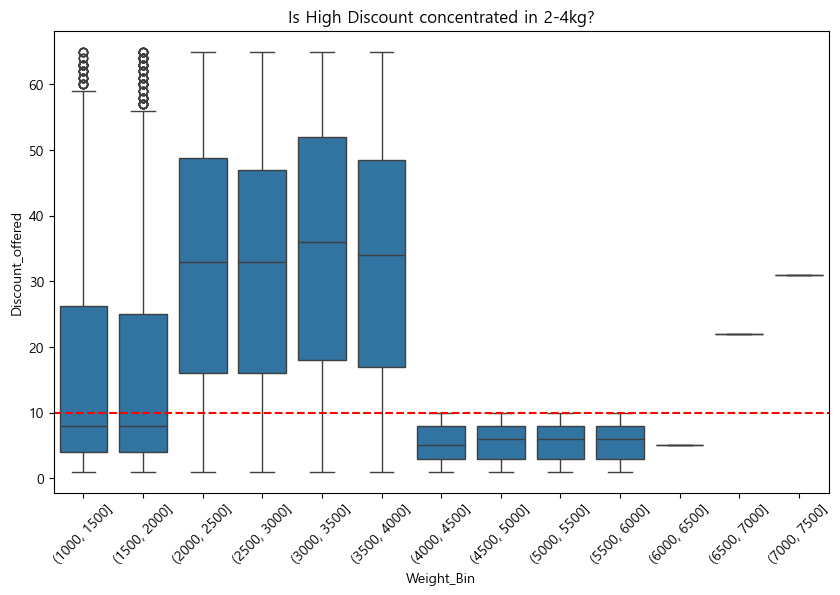

In [41]:
# 특정 프로모션이 2~4kg에 집중되어 있나?

# [1] 무게 구간별 평균 할인폭 확인
discount_by_weight = Train.groupby('Weight_Bin')['Discount_offered'].agg(['mean', 'max', 'count'])

print("--- 무게 구간별 할인폭 실태조사 ---")
print(discount_by_weight)

# [2] 시각화: 2~4kg 구간에 10달러 이상의 할인이 얼마나 몰려있는지 확인
plt.figure(figsize=(10, 6))
sns.boxplot(data=Train, x='Weight_Bin', y='Discount_offered')
plt.axhline(10, color='red', linestyle='--', label='Magic 10$')
plt.xticks(rotation=45)
plt.title('Is High Discount concentrated in 2-4kg?')
plt.show()

* 2~4kg 물건이 늦게 오는 이유는 그 무게의 할인율이 높기 때문인 경우가 많았음. 무게보다는 할인율이 더 큰 영향력이 있다는 걸 알 수 있음
* ! 2~4kg는 샘플수가 충분하지만 6kg 이상 데이터는 count가 1개씩 데이터가 부족함. 
* 4kg 기점으로 할인이 칼같이 잘림. 4kg 넘으면 무거운 물건 할인 해주지 않을 수도 (추측-데이터에는 영향X)

#### 9-2. +다른요소 교차분석

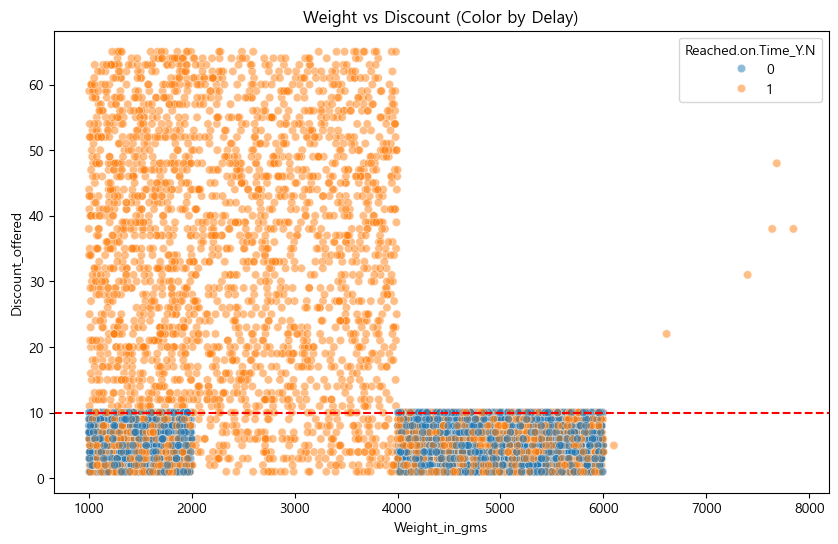

In [42]:
# 무게 x 할인폭

# 무게와 할인폭의 상관관계 시각화 (산점도)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Train, x='Weight_in_gms', y='Discount_offered', hue='Reached.on.Time_Y.N', alpha=0.5)
plt.axhline(10, color='red', linestyle='--')
plt.title('Weight vs Discount (Color by Delay)')
plt.show()

* 무게는 운송 수단에 따라 무게감이 다르다 (비행기 4kg는 무거운 축에 속하지만 배 4kg는 가벼운 축에 속함)
> 무게 x 운송수단 지연율 확인 필요

--- 무게 구간 x 운송수단별 지연율 ---
Mode_of_Shipment    Flight      Road      Ship
Weight_Bin                                    
(1000, 1500]      0.655502  0.635897  0.686667
(1500, 2000]      0.654378  0.633333  0.680604
(2000, 2500]      1.000000  1.000000  1.000000
(2500, 3000]      1.000000  1.000000  1.000000
(3000, 3500]      1.000000  1.000000  1.000000
(3500, 4000]      1.000000  1.000000  0.996124
(4000, 4500]      0.511848  0.432292  0.435424
(4500, 5000]      0.425926  0.375000  0.432727
(5000, 5500]      0.456790  0.464865  0.422392
(5500, 6000]      0.425287  0.460674  0.417079
(6000, 6500]           NaN  1.000000       NaN
(6500, 7000]           NaN  1.000000       NaN
(7000, 7500]           NaN       NaN  1.000000


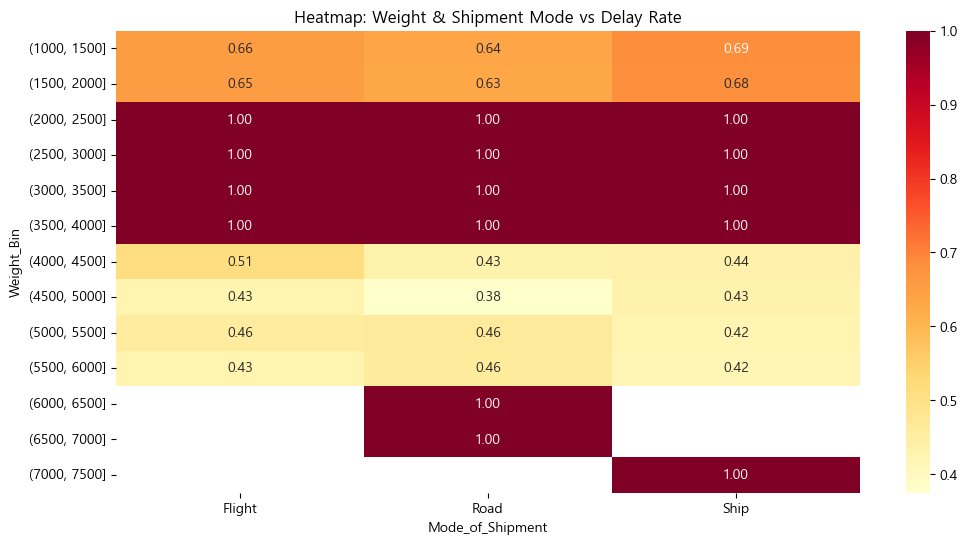

In [43]:
# 무게 X 운송수단별

# [1] 무게 구간(Weight_Bin)과 운송수단별 지연율 교차 분석
weight_ship_pivot = Train.groupby(['Weight_Bin', 'Mode_of_Shipment'])['Reached.on.Time_Y.N'].mean().unstack()

print("--- 무게 구간 x 운송수단별 지연율 ---")
print(weight_ship_pivot)

# [2] 시각화: 히트맵
plt.figure(figsize=(12, 6))
sns.heatmap(weight_ship_pivot, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Heatmap: Weight & Shipment Mode vs Delay Rate')
plt.show()

In [44]:
# 2~4kg 사이인지 아닌지를 1,0으로 바꿈.
def get_cleaned_data(df):
    temp_df = df.copy()
    
    # # [1] 이전 구매 횟수 (6회 이상 뭉치기)
    # temp_df['Prior_purchases_cleaned'] = temp_df['Prior_purchases'].apply(lambda x: x if x < 6 else 6)
    
    # # [2] 제품 중요도 (라벨 인코딩: low=1, medium=2, high=3)
    # mapping = {'low': 1, 'medium': 2, 'high': 3}
    # temp_df['Product_importance'] = temp_df['Product_importance'].map(mapping)
    
    # # [3] 할인 폭 (10달러 초과 여부 - 추가 컬럼 생성1)
    # temp_df['Is_High_Discount'] = (temp_df['Discount_offered'] > 10).astype(int)
    
    # [4] 무게 (2000~4000g 구간 여부 - 추카 컬럼 생성2)
    # 2~4kg 이내는 1, 나머지는 (6이상도) 0
    temp_df['Is_Danger_Weight'] = temp_df['Weight_in_gms'].between(2000, 4000).astype(int)
    
    # #[5] 불필요해진 원본 컬럼들 드랍 (깔끔하게 하려면 (선택사항))
    # temp_df = temp_df.drop(['Prior_purchases'], axis=1)
    
    return temp_df

Train_ready = get_cleaned_data(Train)
Train_ready.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Is_High_Discount,Prior_purchases_cleaned,over_10,Weight_Bin,Is_Danger_Weight
0,D,Road,4,1,261,2,medium,F,9,4158,0,0,2,False,"(4000, 4500]",0
1,F,Ship,3,3,162,2,low,F,26,1659,1,1,2,True,"(1500, 2000]",0
2,B,Ship,3,2,221,2,medium,M,9,4466,0,0,2,False,"(4000, 4500]",0
3,D,Ship,3,5,157,4,medium,F,2,4640,0,0,4,False,"(4500, 5000]",0
4,A,Flight,2,5,272,2,low,M,24,3638,1,1,2,True,"(3500, 4000]",1


### 결론
> 현재 데이터상 고할인-고지연의 상관관계는 뚜렷하나, 그 인과관계를 확정 짓기에는 추가 변수가 부족함. 

* 'ID' ----------------------- X
* 'Warehouse_block' ---------- F물량 가장 많지만 지연율 비슷. 창고위치는 영향 X
* 'Mode_of_Shipment' --------- 할인 규모 앞에서는 평등하게 늦음 / 운송 수단 개선 해결책 X
* 'Customer_care_calls' ------ 전화횟수 많다고 배송 더 빨리오거나 늦어지는 뚜렷한 인과관계 부족 --> 가격 비싼데 지연이라면 자주 전화했을까?
* 'Customer_rating' ---------- 지연 발생해도 평점은 3.46~3.47점대
* 'Cost_of_the_Product'------- 제품이 비쌀수록 무게가 가벼워지는 경향(4~5회 구매구간)이 있어 지연율 하락에 간접적인 영향 --> 비쌀수록 무게가 가벼워지나? 무게당 가격 (value)이 더 중요할수도? 그리고 log 취해서 그래프 다시 그려보는 것도 방법?
* 'Prior_purchases' ---------- 6회이상 단골에게 고할인 주는 마케팅 정책 때문에 지연율이 다시 높아짐 U자형 패턴 -> u자형 패턴인건 맞는데 단골 고할인 마케팅 정책여부는 모르잖아? 데이터에 안 나옴.
* 'Product_importance' ------- 고가/저가 제품군 분류 보조 지표 (사람이 매긴 등급)--> 무게당 가격으로 치환해볼까? / > Low: 지연율 59.7% / Medium: 지연율 58.5% / High: 지연율 64.8% / * 샘플 수(count): high (768개), low(4,214개), medium(3,817개) / 노이즈가 섞여있을 확률 큼 / * 추측의 영역 : 배송난이도? 중요도가 high인 제품들은 아마 비싸거나, 깨지기 쉽거나, 크기가 큰 제품일 가능성. 검수 과정이 더 까다롭거나 배송 기사님이 더 조심조심 다루다 보니 오히려 시간이 더 걸리지 않을까? --- 결론: 중요도가 높다고 빨리가지는 않음. 
* 'Gender' ------------------- X
* 'Discount_offered' --------- ⭐ 주범. 10.5달러 임계점 넘으면 배송 수단 , 창고 불문 지연율 100%
* 'Weight_in_gms' ------------ ⭐ 2~4kg 구간에서 지연 집중되는 위험 무게 패턴 + 할인과 결합시 가장 영향력이 큼

* 'Reached.on.Time_Y.N' ----------> 정답

--- [결과] 새로운 변수들의 지연율 상관계수 ---
Reached.on.Time_Y.N    1.000000
Discount_offered       0.398429
Value_Density          0.080144
Care_per_Cost         -0.002240
Log_Cost              -0.071698
Weight_in_gms         -0.261415
Name: Reached.on.Time_Y.N, dtype: float64


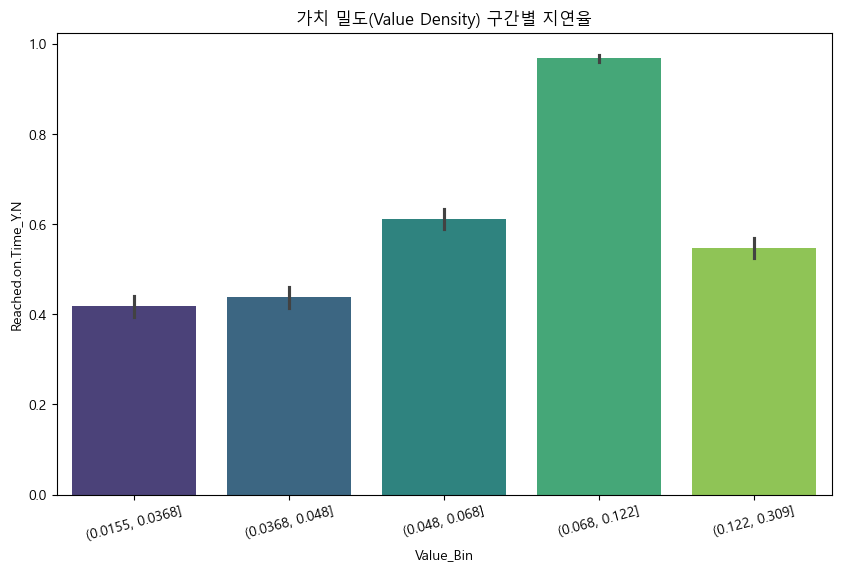


--- [결과] 제품 중요도별 평균 가치 밀도 ---
Product_importance
1    0.085479
2    0.075860
3    0.062151
Name: Value_Density, dtype: float64


In [71]:
# [1] 새로운 수사 단서(파생 변수) 생성
def create_investigative_features(df):
    temp = df.copy()
    
    # 1. 가치 밀도: 작고 비싼 녀석인가, 크고 싼 녀석인가?
    temp['Value_Density'] = temp['Cost_of_the_Product'] / temp['Weight_in_gms']
    
    # 2. 로그 가격: 가격의 편차를 줄여서 모델의 시야를 확보
    temp['Log_Cost'] = np.log1p(temp['Cost_of_the_Product'])
    
    # 3. 분노의 전화 지수: 비싼 물건인데 전화까지 많이 했다면?
    temp['Care_per_Cost'] = temp['Customer_care_calls'] / temp['Cost_of_the_Product']
    
    return temp

# 데이터 적용 (Train_ready가 현재 사용 중인 데이터프레임 이름이라고 가정)
Train_final = create_investigative_features(Train_ready)

# [2] 핵심 변수들과 지연율의 상관관계 확인
cols_to_check = ['Reached.on.Time_Y.N', 'Value_Density', 'Log_Cost', 'Care_per_Cost', 'Discount_offered', 'Weight_in_gms']
correlation_matrix = Train_final[cols_to_check].corr()

print("--- [결과] 새로운 변수들의 지연율 상관계수 ---")
print(correlation_matrix['Reached.on.Time_Y.N'].sort_values(ascending=False))

# [3] 시각화: '무게당 가격'이 높을수록(비싸고 작을수록) 지연이 적은가?
plt.figure(figsize=(10, 6))
# 가치 밀도를 5개 구간으로 나누어 지연율 확인
Train_final['Value_Bin'] = pd.qcut(Train_final['Value_Density'], q=5)
sns.barplot(data=Train_final, x='Value_Bin', y='Reached.on.Time_Y.N', palette='viridis')
plt.title("가치 밀도(Value Density) 구간별 지연율")
plt.xticks(rotation=15)
plt.show()

# [4] 보너스: '중요도'에 따른 무게당 가격 차이 확인
print("\n--- [결과] 제품 중요도별 평균 가치 밀도 ---")
print(Train_final.groupby('Product_importance')['Value_Density'].mean())

> 결론
* 새로운 변수들의 지연율 상관계수-Log_Cost(-0.07): 원본 Cost와 비슷해 보이지만, $np.log1p$를 취하면 상관계수 숫자는 비슷해도 모델이 계산하기에는 훨씬 편함
* 제품 중요도별 평균 가치 밀도 : 비싸고 작아서 '중요'한 상품일수록, 아주 미세하게 더 늦어지는 경향이 있다! > 조심히 다루거나 검수 ?

### 히트맵 확인

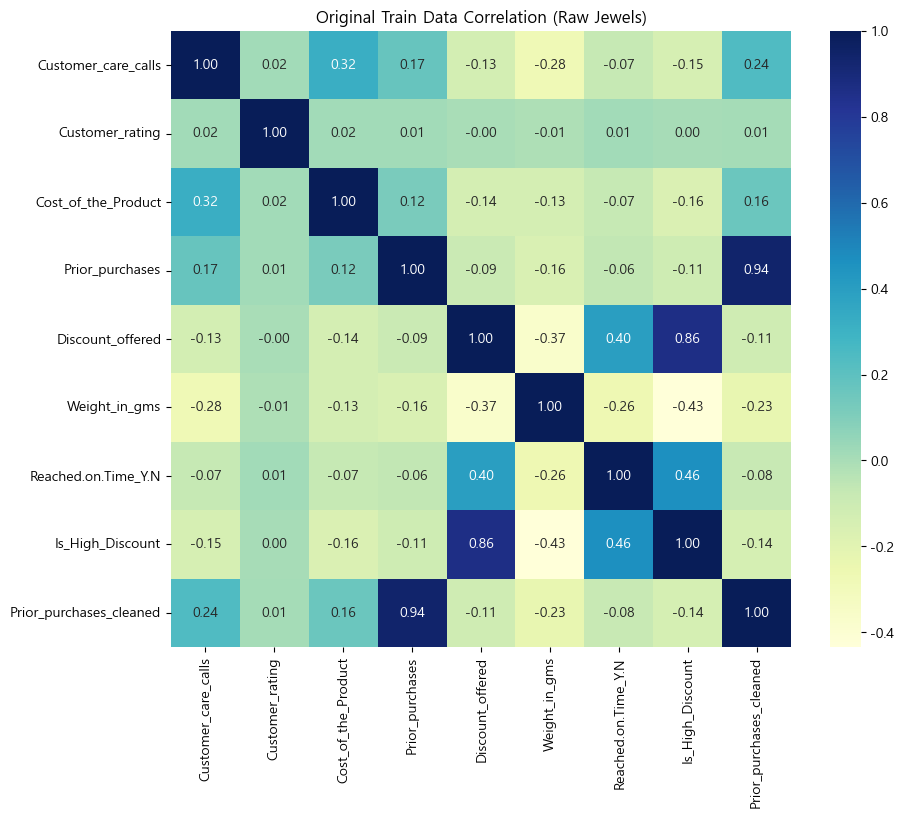

--- 원본 데이터 지연율(Reached.on.Time_Y.N) 상관계수 ---
Reached.on.Time_Y.N        1.000000
Is_High_Discount           0.464082
Discount_offered           0.398429
Customer_rating            0.014894
Prior_purchases           -0.062048
Cost_of_the_Product       -0.073743
Customer_care_calls       -0.074828
Prior_purchases_cleaned   -0.075973
Weight_in_gms             -0.261415
Name: Reached.on.Time_Y.N, dtype: float64


In [45]:
# [1] 원본 데이터에서 숫자형 컬럼만 골라내기
# (파이썬이 자동으로 해주지만, 명시적으로 보여주는 게 공부에 좋습니다!)
original_num_cols = Train.select_dtypes(include=['number']).columns

# [2] 원본 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(Train[original_num_cols].corr(), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Original Train Data Correlation (Raw Jewels)')
plt.show()

# [3] 원본 상태의 지연율 상관관계 순위
print("--- 원본 데이터 지연율(Reached.on.Time_Y.N) 상관계수 ---")
print(Train[original_num_cols].corr()['Reached.on.Time_Y.N'].sort_values(ascending=False))

In [46]:
# [1] 데이터프레임 이름 확인 (Train_ready로 사용하신다면 아래와 같이!)
# 만약 이름이 그냥 Train이라면 Train_ready = Train.copy() 를 먼저 해주세요.

# 1. 할인 10.5달러 초과
Train_ready['Is_High_Discount'] = (Train_ready['Discount_offered'] > 10.5).astype(int)

# 2. 무게 2,000g ~ 4,000g 구간
Train_ready['Is_Danger_Weight'] = Train_ready['Weight_in_gms'].between(2000, 4000).astype(int)

# 3. 중요도 숫자 매핑 (low: 1, medium: 2, high: 3)
mapping = {'low': 1, 'medium': 2, 'high': 3}
Train_ready['Product_importance'] = Train_ready['Product_importance'].map(mapping)

# 4. 구매 횟수 뭉치기 (6회 이상은 다 6으로)
Train_ready['Prior_purchases_cleaned'] = Train_ready['Prior_purchases'].apply(lambda x: x if x < 6 else 6)

print("✅ 모든 변수가 재생성되었습니다!")

✅ 모든 변수가 재생성되었습니다!


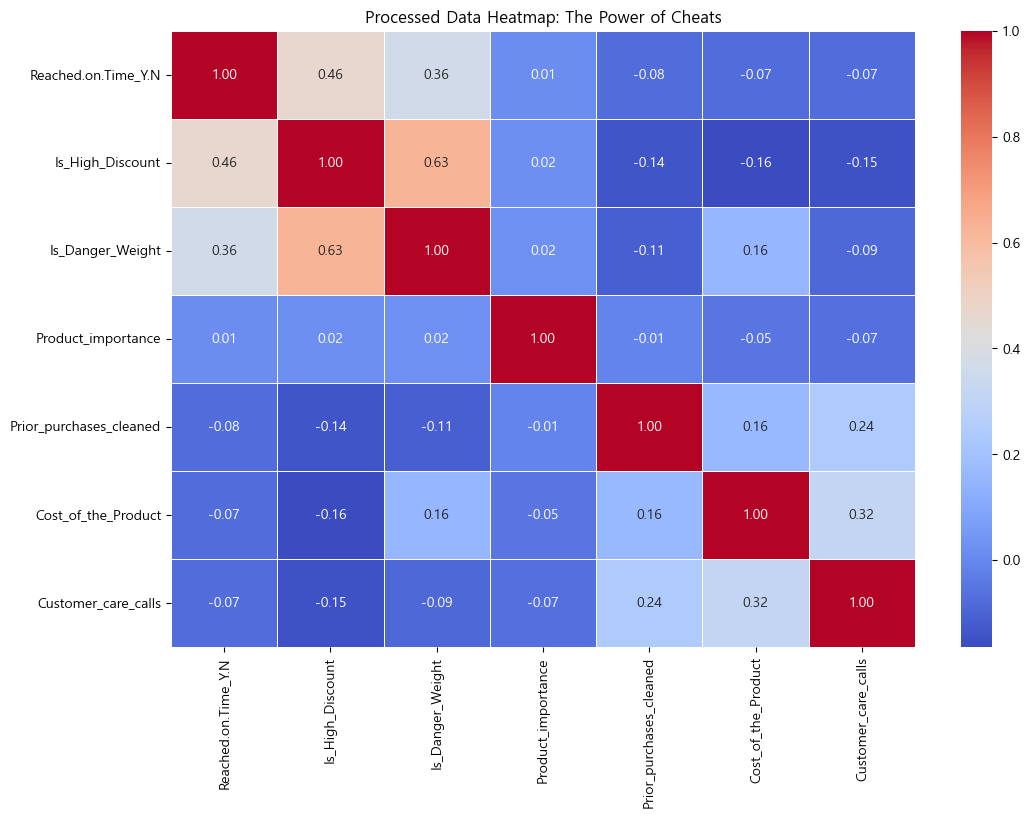

--- 가공본 지연율 상관계수 서열 (절대값 기준) ---
Reached.on.Time_Y.N        1.000000
Is_High_Discount           0.464082
Is_Danger_Weight           0.364093
Prior_purchases_cleaned    0.075973
Customer_care_calls        0.074828
Cost_of_the_Product        0.073743
Product_importance         0.013011
Name: Reached.on.Time_Y.N, dtype: float64


In [47]:
# [1] 상관분석에 사용할 숫자형 변수들만 선택
# 만약 이름이 다르면 학생이 만든 이름으로 살짝 수정해줘!
ready_cols = [
    'Reached.on.Time_Y.N',   # 타겟 (지연 여부)
    'Is_High_Discount',     # 할인 치트키 (10달러 초과)
    'Is_Danger_Weight',     # 무게 치트키 (2~4kg 구간)
    'Product_importance',   # 중요도 (숫자 매핑 완료)
    'Prior_purchases_cleaned', # 구매 횟수 (6회 이상 뭉침)
    'Cost_of_the_Product',  # 제품 가격
    'Customer_care_calls'   # 고객 전화 횟수
]

# [2] 데이터프레임에서 위 컬럼들만 추출 (숫자가 아닌 건 자동으로 걸러짐)
ready_corr = Train_ready[ready_cols].corr()

# [3] 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(ready_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Processed Data Heatmap: The Power of Cheats')
plt.show()

# [4] 지연율과의 상관계수 '절대값' 순위 (누가 제일 영향력이 큰가!)
print("--- 가공본 지연율 상관계수 서열 (절대값 기준) ---")
print(ready_corr['Reached.on.Time_Y.N'].abs().sort_values(ascending=False))